In [1]:
from comet_ml import Experiment
# import tensorflow as tf
# gpus = tf.config.list_physical_devices('GPU')
# print("GPUs disponibles:", gpus)


In [7]:
import numpy as np
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# !git clone https://github.com/emiliodelgadouy/utils.git

In [8]:
from matplotlib import pyplot as plt
from utils.PatchSequence import PatchSequence
from utils.Dataset import Dataset

/opt/projects/tesis/utils/Dataset.py:249: UserWarning: registration of accessor <class 'utils.Dataset._RenderAccessor1'> under name 'render' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("render")
/opt/projects/tesis/utils/Dataset.py:263: UserWarning: registration of accessor <class 'utils.Dataset._RenderAccessor2'> under name 'stats' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("stats")


In [9]:
dataset = Dataset(lateralize_images=True, dataset_csv="../ds_balanced.csv")

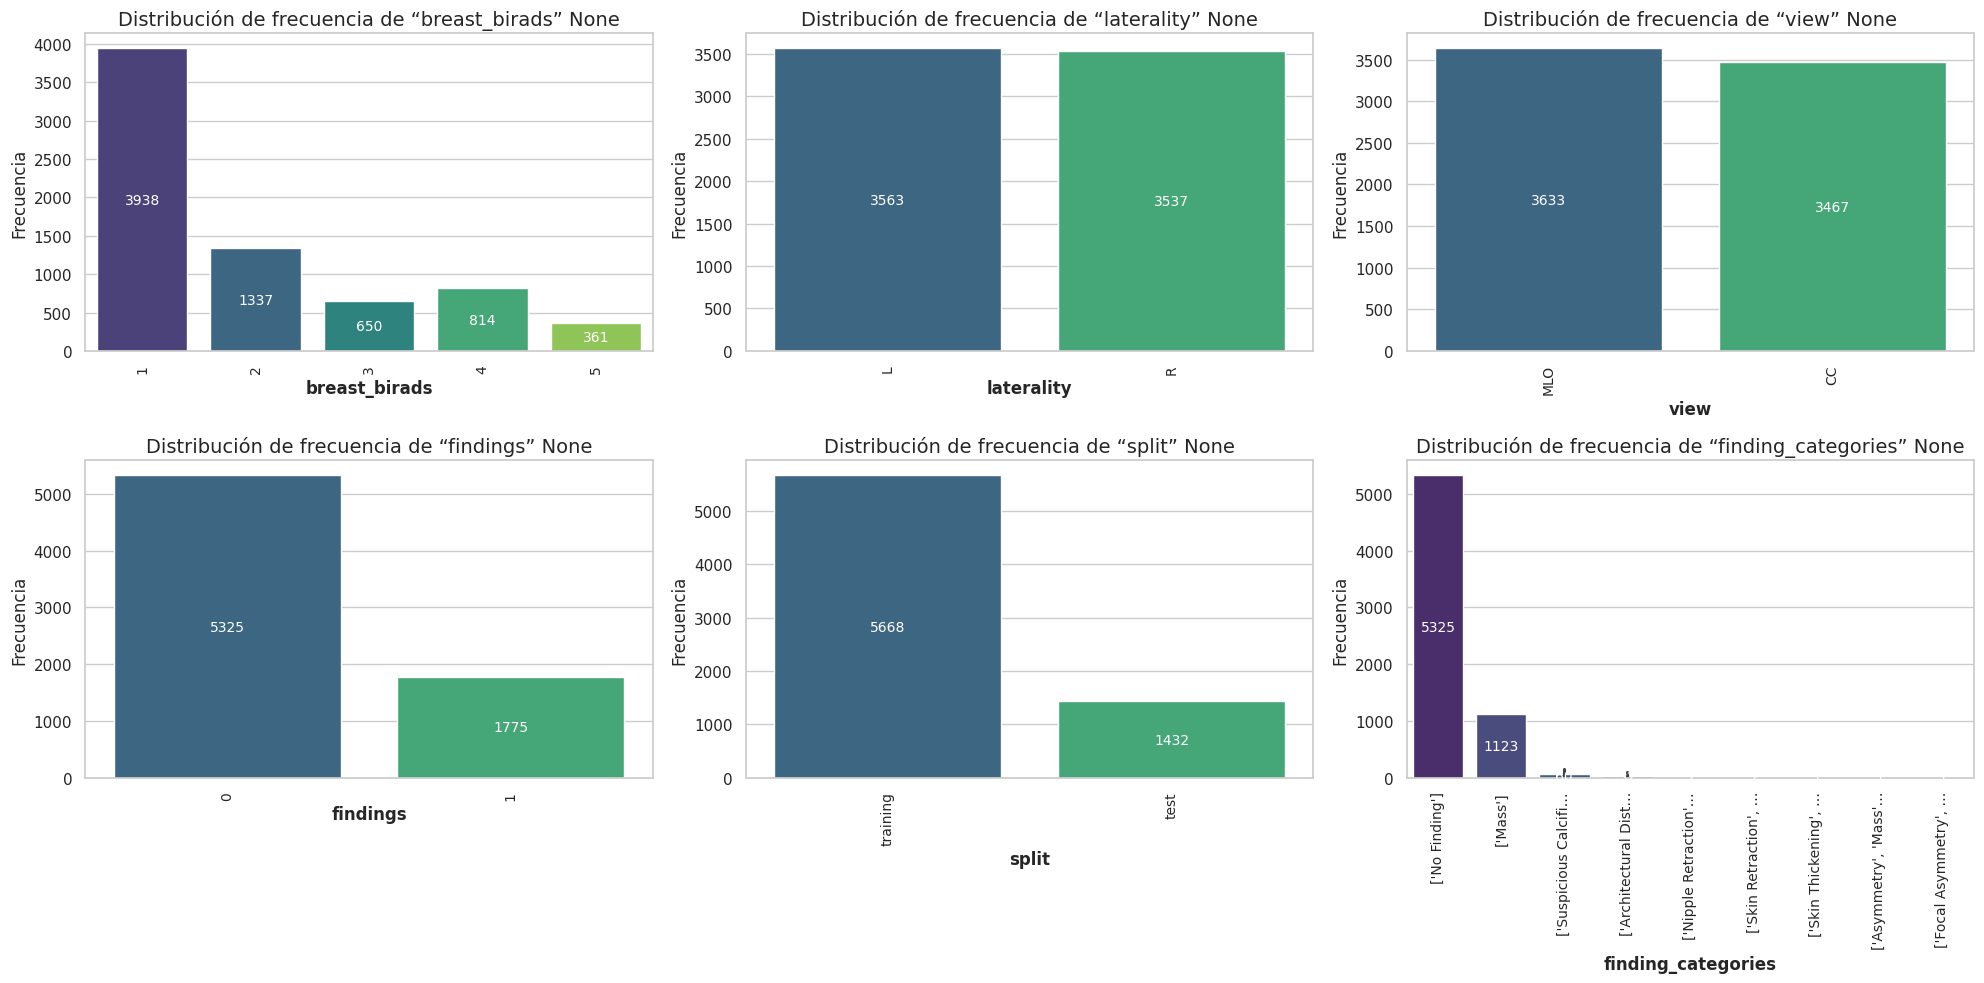

In [10]:
dataset.stats()

In [13]:
dataset.render()

Output()

In [7]:
# from google.colab import auth
# auth.authenticate_user()
# !sudo pip install --no-cache-dir -U crcmod
# !gsutil cp gs://helen-data/dumps/dump_cache_reduced_half.npz ./

In [14]:
dataset.load_dump('ds_balanced.npz')
# dataset.load_dump('dump_cache_reduced_half.npz')

KeyboardInterrupt: 

In [9]:
# dataset.stats()

In [10]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 800

In [11]:
import gc
import time
import random
import numpy as np
import optuna
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Dividir dataset una sola vez
full_train = dataset[(dataset["split"] == "training")]
ds_test    = dataset[(dataset["split"] == "test")]
ds_train, ds_val = train_test_split(
    full_train,
    test_size=0.20,
    random_state=42,
    stratify=full_train["findings"]
)

def objective(trial):
    # ==== SEEDS PARA REPRODUCIBILIDAD ====
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    # ==== COMET ====
    experiment = Experiment(
        api_key="W8IluWhLfvXgLr8ggg1bwZKTf",
        project_name="analisis",
        workspace="emiliodelgadouy",
        auto_output_logging="simple",
        log_code=False
    )
    experiment.set_name(f"trial_balanced_bug_{trial.number}")

    # ==== HIPERPARÁMETROS ====
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate  = trial.suggest_float('dropout_rate', 0.2, 0.6)
    l2_reg        = trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True)
    unfreeze_pct  = trial.suggest_float("unfreeze_pct", 0.0, 0.3)
    optimizer     = Adam(learning_rate=learning_rate)

    experiment.log_parameters({
        "learning_rate": learning_rate,
        "dropout_rate": dropout_rate,
        "l2_reg": l2_reg,
        "backbone": "InceptionV3",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS,
        "unfreeze_pct": unfreeze_pct
    })

    # ==== GENERADORES ====
    train_generator = PatchSequence(
        ds_train,
        batch_size=BATCH_SIZE,
        patch_size=IMG_SIZE,
        shuffle=True,
        preprocess_fn=preprocess_input
    )
    val_generator = PatchSequence(
        ds_val,
        batch_size=BATCH_SIZE,
        patch_size=IMG_SIZE,
        shuffle=False,
        preprocess_fn=preprocess_input
    )
    test_generator = PatchSequence(
        ds_test,
        batch_size=BATCH_SIZE,
        patch_size=IMG_SIZE,
        shuffle=False,
        preprocess_fn=preprocess_input
    )

    # ==== BACKBONE ====
    base = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    for layer in base.layers:
        layer.trainable = False

    # Unfreeze parcial
    n_total = len(base.layers)
    n_unfreeze = int(n_total * unfreeze_pct)
    if n_unfreeze > 0:
        for layer in base.layers[-n_unfreeze:]:
            layer.trainable = True

    # ==== PESOS DE CLASE ====
    labels = np.array(ds_train["findings"])
    classes = np.unique(labels)
    weights = class_weight.compute_class_weight('balanced', classes=classes, y=labels)
    class_weights = dict(zip(classes, weights))

    # ==== CABEZA DEL MODELO ====
    x = base.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(
        512,
        activation='relu',
        kernel_regularizer=l1_l2(l1=1e-4, l2=l2_reg)
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc_roc', curve='ROC')]
    )

    # ==== ENTRENAMIENTO ====
    t0 = time.time()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        class_weight=class_weights,
        verbose=1
    )
    elapsed = time.time() - t0
    experiment.log_metric("training_time_sec", elapsed)

    # ==== EVALUACIÓN EN TEST ====
    score = model.evaluate(test_generator, verbose=1)
    experiment.log_metric("final_test_loss", score[0])
    experiment.log_metric("final_test_accuracy", score[1])
    experiment.log_metric("final_test_auc_roc", score[2])

    experiment.end()

    # ==== LIBERAR MEMORIA ====
    del model, train_generator, val_generator, test_generator
    tf.keras.backend.clear_session()
    gc.collect()

    return score[1]


In [ ]:
study = optuna.create_study(direction='maximize', study_name='optuna_inception')
study.optimize(objective, n_trials=20)

print("accuracy", study.best_value)
print("params", study.best_params)

[I 2025-08-14 21:54:51,256] A new study created in memory with name: optuna_inception
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/emiliodelgadouy/analisis/df0bedcba67d436ea7c7e3900ebd4283

I0000 00:00:1755219296.178878   38342 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9945 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/800


I0000 00:00:1755219305.843626   38506 service.cc:152] XLA service 0x7bda90005200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755219305.843656   38506 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-08-14 21:55:06.126523: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755219307.725551   38506 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/90 ━━━━━━━━━━━━━━━━━━━━ 38:17 26s/step - accuracy: 0.5000 - auc_roc: 0.4686 - loss: 3.5139

I0000 00:00:1755219323.833877   38506 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 196ms/step - accuracy: 0.5747 - auc_roc: 0.5935 - loss: 3.2838 - val_accuracy: 0.5440 - val_auc_roc: 0.6145 - val_loss: 3.2895
Epoch 2/800
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.5844 - auc_roc: 0.6146 - loss: 3.0247 - val_accuracy: 0.5241 - val_auc_roc: 0.6284 - val_loss: 2.9718
Epoch 3/800
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5802 - auc_roc: 0.6217 - loss: 2.8428 - val_accuracy: 0.5128 - val_auc_roc: 0.6619 - val_loss: 2.8162
Epoch 4/800
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.5965 - auc_roc: 0.6333 - loss: 2.6608 - val_accuracy: 0.6094 - val_auc_roc: 0.7091 - val_loss: 2.6174
Epoch 5/800
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.6038 - auc_roc: 0.6442 - loss: 2.5010 - val_accuracy: 0.6193 - val_auc_roc: 0.6697 - val_loss: 2.4567
Epoch 6/800
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.6146 - auc_roc: 0.6519 - loss: 2.3447 - val_accuracy: 0.5696 - val_auc_roc: 0.7062 - val_loss: